In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score


###########

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

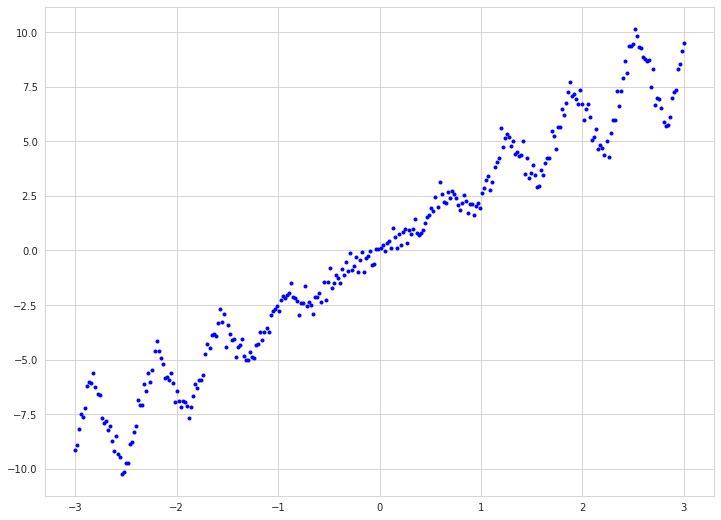

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel(r"$\hat{y}$", fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=ylabel)
    plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

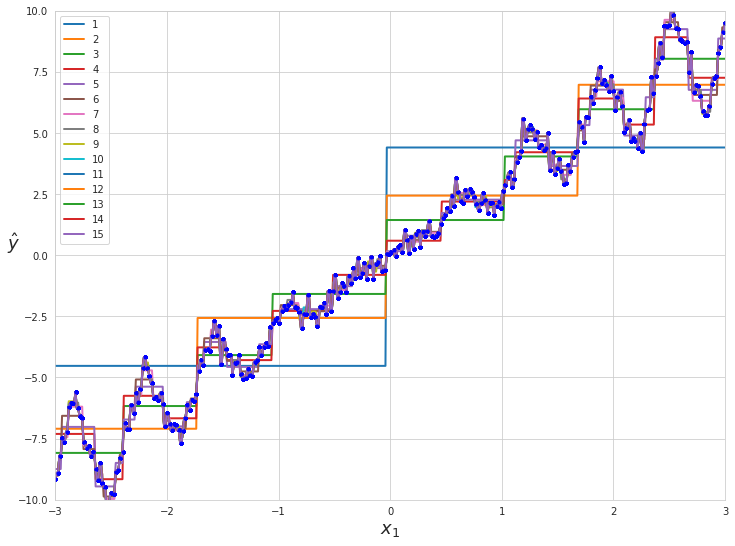

In [5]:
for d in range(1,16):
    dtr = DecisionTreeRegressor(max_depth=d)
    dtr.fit(X, y)
    plot_regression_predictions(dtr, X, y, ylabel=d)
    plt.plot(X.reshape(-1), y.reshape(-1), "b.");

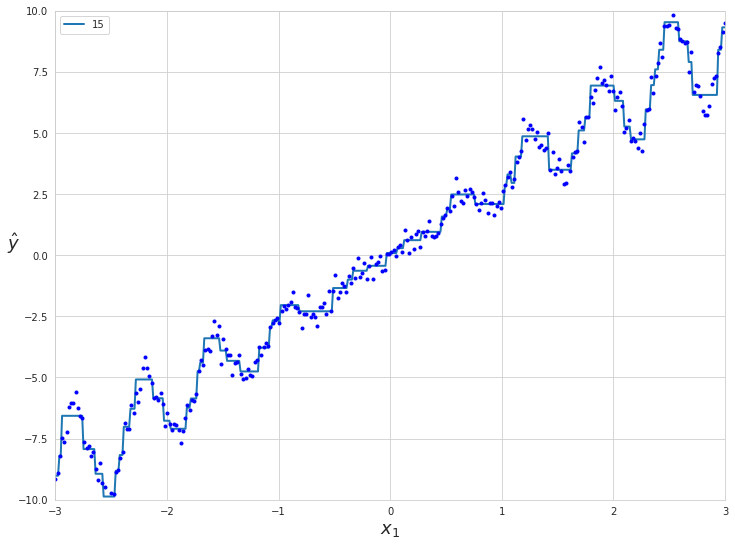

In [8]:
plot_regression_predictions(DecisionTreeRegressor(max_depth=6).fit(X,y), X, y, ylabel=d)
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

`max_depth=6` даёт неплохой результат, отражающий общий смысл кривой и ещё не успевает заучить положения точек. Далее уже variance начинает увеличиваться, точки всё больше и больше заучиваются.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [10]:
from scipy.stats import binom  


prob_one = np.arange(0,1.05,0.02)
prob_many = []

# ищем вероятность, что событие наступит ровно i раз из 101-го, и складываем все i>51
for p in prob_one:
    prob_many.append(sum(binom(n = 101, p = p).pmf(np.arange(51,102))))

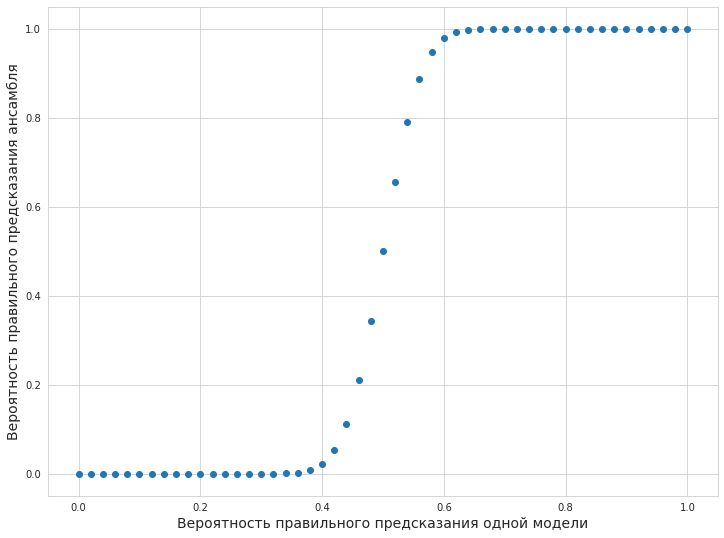

In [11]:
plt.scatter(prob_one, prob_many)
plt.xlabel("Вероятность правильного предсказания одной модели", fontsize=14)
plt.ylabel("Вероятность правильного предсказания ансамбля", fontsize=14)
None

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [13]:
p = 0.65
n_models = np.arange(1, 102, 2)
prob_many = []

# бежим по нечётному числу моделей, аналогично проверяем чтобы больше половины предсказывали правильно
for n in n_models:
    prob_many.append(sum(binom(n = n, p = p).pmf(np.arange(n//2+1, n+1))))

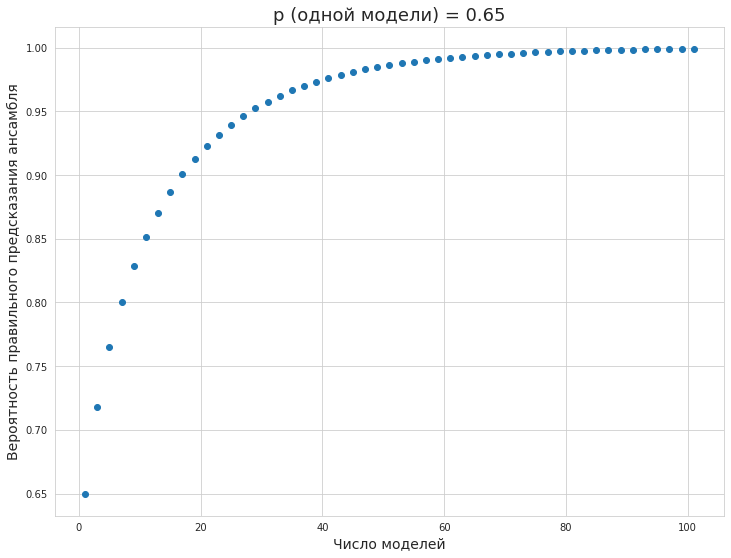

In [14]:
plt.scatter(n_models, prob_many)
plt.title(f"p (одной модели) = {p}", fontsize=18)
plt.xlabel("Число моделей", fontsize=14)
plt.ylabel("Вероятность правильного предсказания ансамбля", fontsize=14)
None

Опишите ваши наблюдения:

* для $101$ модели уверенность суммарного предсказания растёт очень быстро, и уже при $p=0.6$ вероятность правильного предсказания ансамбля моделей $>0.9$;
* если вероятность предсказания каждой модели не самая хорошая, но $>0.5$ (хотя бы $0.65$), то уже для 20 таких моделей мы будем иметь хороший суммарный результат.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [213]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        if not self.max_features:
            mf = X.shape[1]
        else:
            mf = self.max_features
        n_features = X.shape[1]

        for i in range(self.n_estimators):
            # фиксируем рандом
            np.random.seed(self.random_state+1)
            # выбираем max_features фичей
            self.feat_ids_by_tree.append(np.random.choice(range(n_features), size=mf, replace=False))
            # создаём подвыборку
            train_indexes = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_train = np.array([X[j] for j in train_indexes])  # берём подвыборку для X
            X_train = X_train[:, self.feat_ids_by_tree[i]].reshape(-1, mf)  # выбираем нужные фичи
            y_train = np.array([y[j] for j in train_indexes])  # берём подвыборку для y
            # обучаем
            dt = DecisionTreeClassifier(max_depth=self.max_depth, 
                                        max_features=None, 
                                        random_state=self.random_state)
            dt.fit(X_train, y_train)
            # запоминаем дерево
            self.trees.append(dt)
            
        return self
            
    def predict_proba(self, X):
        if not self.max_features:
            mf = X.shape[1]
        else:
            mf = self.max_features
            
        preds = np.zeros((X.shape[0], mf))
        for i, tree in enumerate(self.trees):
            # тестируем только по параметрам, на которых обучалась
            feature_indexes = self.feat_ids_by_tree[i]
            X_test = X[:, feature_indexes]
            # предсказываем
            tree_pred = tree.predict_proba(X_test)
            # учитывая прошлые предсказания считаем вероятность
            preds = preds + tree_pred
        
        preds = preds / self.n_estimators  # считаем среднюю вероятность (делим на число деревьев)
        
        return preds
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [215]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

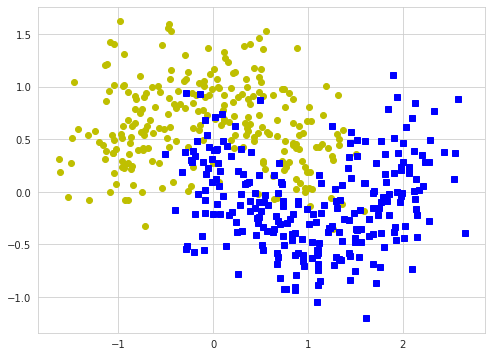

In [216]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [218]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

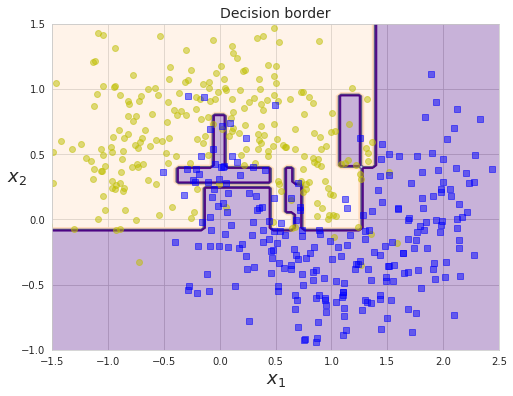

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [238]:
RFCC_model = GridSearchCV(RandomForestClassifierCustom(random_state=42), 
                          {"n_estimators": list(range(1,20)),
                           "max_depth": list(range(1,50,2)),
                           "max_features": [1, 2]},
                          scoring='accuracy',
                          cv=5
                         ).fit(X_train, y_train)

In [247]:
print(f'best accuracy = {RFCC_model.best_score_:.3f}')
print()
print('best_parameters:\n', RFCC_model.best_params_)

best accuracy = 0.909

best_parameters:
 {'max_depth': 5, 'max_features': 2, 'n_estimators': 1}


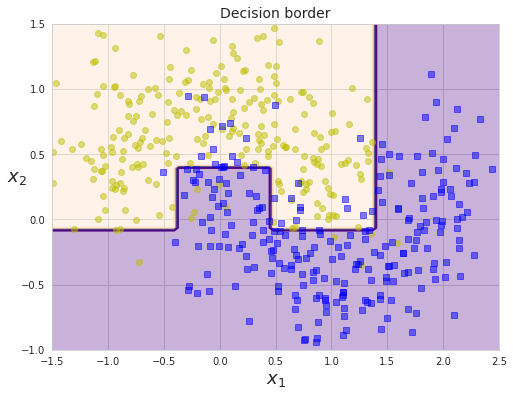

In [240]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(RFCC_model.best_estimator_, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

С другими scoring результат такой же

$~$

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выяснили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [241]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [242]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [289]:
max_features = range(1, X_train.shape[1]+1, 2)

RFC_data = pd.DataFrame()

for mf in max_features:
    rfc = RandomForestClassifier(max_features=mf, random_state=1337)
    rfc.fit(X_train, y_train)
    RFC_data[str(mf)] = base_model_pair_correlation(rfc, X_test)

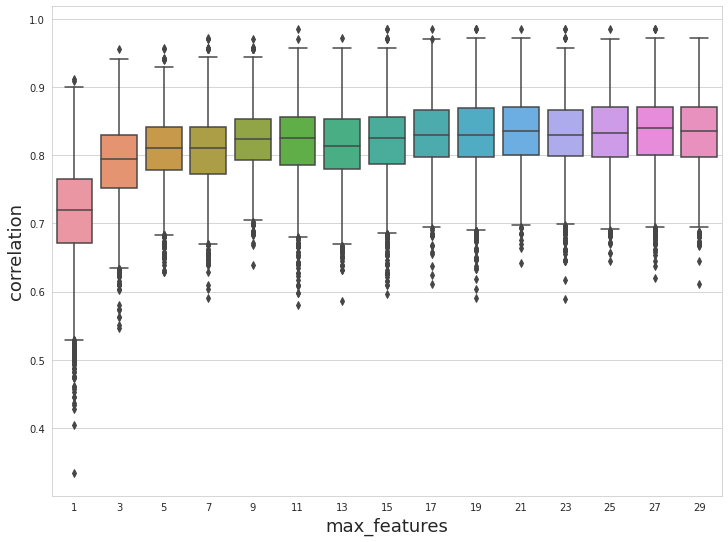

In [296]:
sns.boxplot(data=RFC_data)
plt.xlabel("max_features", fontsize=18)
plt.ylabel("correlation", fontsize=18)
None

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [300]:
max_depth = range(1, 15)

RFC_data = pd.DataFrame()

for md in max_depth:
    rfc = RandomForestClassifier(max_depth=md, random_state=1337)
    rfc.fit(X_train, y_train)
    RFC_data[str(md)] = base_model_pair_correlation(rfc, X_test)

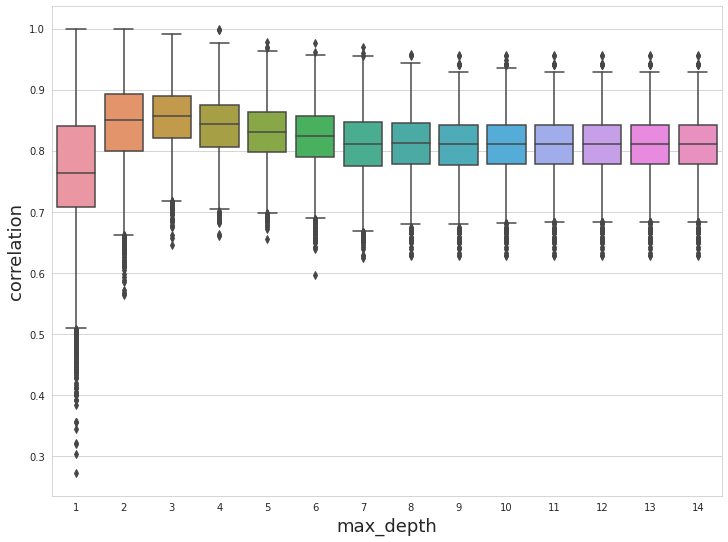

In [301]:
sns.boxplot(data=RFC_data)
plt.xlabel("max_depth", fontsize=18)
plt.ylabel("correlation", fontsize=18)
None

Опишите ваши наблюдения:

* При всех вариантах max_features есть корреляция базовых моделей. С увеличением параметра корреляция растёт до выхода на плато;
* С ростом глубины дерева корреляция немного падает, но остаётся довольно сильной.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [3]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/home/elem/.local/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [4]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [5]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
[19:27:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old b

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [9]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [10]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [42]:
# обучаем

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

In [43]:
# запоминаем корреляции

correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

In [234]:
# создаём датафрэйм

rows = set([est[0].__class__.__name__ for est in correlations])
cols = set([est[1].__class__.__name__ for est in correlations])
together = rows | cols
BMPCfVC_data = pd.DataFrame(index = together, columns=together)

In [81]:
# заполняем датафрэйм

for est1, est2, corr in correlations:
    BMPCfVC_data.loc[est1.__class__.__name__, est2.__class__.__name__] = corr
    BMPCfVC_data.loc[est2.__class__.__name__, est1.__class__.__name__] = corr
#     print(est1.__class__.__name__)


# диагональ
for est in together:
    BMPCfVC_data.loc[est, est] = 1

BMPCfVC_data = BMPCfVC_data.astype(float)
BMPCfVC_data

,LGBMClassifier,XGBClassifier,CatBoostClassifier,RandomForestClassifier,DecisionTreeClassifier,LogisticRegression,XGBRFClassifier,GaussianNB,ExtraTreesClassifier,SVC,KNeighborsClassifier
LGBMClassifier,1,0.848501,0.882031,0.914669,0.861266,0.78924,0.91622,0.742768,0.859303,0.389275,0.401503
XGBClassifier,0.848501,1,0.934455,0.902006,0.804967,0.817463,0.947816,0.718442,0.868802,0.238971,0.307965
CatBoostClassifier,0.882031,0.934455,1,0.94507,0.787569,0.870647,0.935241,0.824656,0.95272,0.310658,0.317207
RandomForestClassifier,0.914669,0.902006,0.94507,1,0.813489,0.837771,0.933861,0.798843,0.921565,0.405527,0.392417
DecisionTreeClassifier,0.861266,0.804967,0.787569,0.813489,1,0.739982,0.882673,0.682771,0.774954,0.282014,0.313329
LogisticRegression,0.78924,0.817463,0.870647,0.837771,0.739982,1,0.807342,0.892515,0.869349,0.401675,0.269734
XGBRFClassifier,0.91622,0.947816,0.935241,0.933861,0.882673,0.807342,1,0.73472,0.88791,0.321431,0.385889
GaussianNB,0.742768,0.718442,0.824656,0.798843,0.682771,0.892515,0.73472,1,0.852299,0.422335,0.231372
ExtraTreesClassifier,0.859303,0.868802,0.95272,0.921565,0.774954,0.869349,0.88791,0.852299,1,0.358855,0.322398
SVC,0.389275,0.238971,0.310658,0.405527,0.282014,0.401675,0.321431,0.422335,0.358855,1,0.56598


In [244]:
# поробуем скорректировать набор моделей, убрав коррелирующие
# (тут уже даже не просто убирание коррелирующих а перебор был)

new_base_models = [
#     ("DT", dt), 
#     ("RF", rf), 
#     ("ETC", etc), 
#     ("KNN", knn), 
    ("SVC_LIN", svc_lin), 
#     ("SVC_RBF", svc_rbf), 
#     ("CAT", cat), 
#     ("LGBM", lgbm), 
#     ("LGBM_RF", lgbm_rf), 
#     ("XGB", xgb), 
#     ("XGB_RF", xgb_rf), 
#     ("LR", lr), 
    ("NB", nb)
]

In [247]:
from sklearn.metrics import f1_score

new_voting_soft = VotingClassifier(new_base_models, voting='soft')
new_voting_soft.fit(X_train, y_train)
preds = new_voting_soft.predict(X_test)

print(f"{new_voting_soft.__class__.__name__}: {f1_score(y_test, preds)}")

VotingClassifier: 0.9072164948453608


**Нужный скор получен**, однако эти подгоны набора моделей выглядят как какой-то data leakage :)

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

<img src='https://sun9-6.userapi.com/impg/5Y5yqFEKeEiDY65o0njq6zAmZBC9z0WbmrzQwg/BRdELIrgu5Y.jpg?size=545x510&quality=95&sign=1ef8110c57ba0810c89b7a78a401951f&type=album'>

░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░███████░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░███░░░░░███░░░░░░░░░░░░░░░░
░░░░░░░░░░████░░░░░░░░░░██░░░░░░░░░░░░░░
░░░░░░░░░██░░░░░░░░░░░░░░░██░░░░░░░░░░░░
░░░░░░░░██░▒▒▒▒▒▒░░░▒▒▒▒▒░░░██░░░░░░░░░░
░░░░░░░██░░▒░░░░░░▒▒▒░░░▒░░░░██░░░░░░░░░
░░░░░░░█░░░░░██░░░░░██░░░░░░░░██░░░░░░░░
░░░░░░░█░░░░░██░░░░░██░░░░░░░░░█░░░░░░░░
░░░░░░░█░░░░░░░░░░░░░░░░░░░░░░█░░░░░░░░░
░░░░░░░█░░░░░░░░░░░██░░░░░░░░░█░░░░░░░░░
░░░░░░░█░░░░░░██████░░░░░░░░░█░░░░░░░░░░
░░░░░░░██░░░░░░░░░░░░░░░░░░░█░░░░░░░░░░░
░░░░░░░░███░░░░░░░░▄█▀▀▀▄░░█░░░░░░░░░░░░
░░░░░░░░░░███░░▄█▀▀░░░░█░███░░░░░░░░░░░░
░░░░░░░░░░▄▄▄█████████████░░░░░░░░░░░░░░
░░░░░░░░▐█░░░░░░░█▀▀▄░░░░░░░░░░░░░░░░░░░
░░░░░░░░▀░░░░░░░░░░░█▀█░░░░░░░░░░░░░░░░░
░░░░░░▐░░░░░░░░░░░▀▀░██▌░░░░░░░░░░░░░░░░
░░░░░░░█░░░░░░░░░░░░░▀░▌░░░░░░░░░░░░░░░░
░░░░░░░░▄░░░░░░░░░░░░▄█░░░░░░░░░░░░░░░░░
░░░░░░░░░▀█▄░░░░░░▄▄█░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░▀▀▀█▄▄▌░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░


Спасибо за внимание

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**